<a href="https://colab.research.google.com/github/xhxuciedu/CS206/blob/master/l1_trend_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $\ell_1$ trend filtering

## Introduction

The problem of estimating underlying trends in time series data arises in a variety of disciplines. The $\ell_1$ trend filtering method produces trend estimates $x$ that are piecewise linear from the time series $y$.

The $\ell_1$ trend estimation problem can be formulated as
    \begin{array}{ll}
    \mbox{minimize}   &  (1/2)||y-x||_2^2 + \lambda ||Dx||_1,
    \end{array}
with variable $x\in R^n$ , and problem data $y\in R^n$ and $\lambda$, with $\lambda >0$.
$D$ is the $(n-2)\times n$ second difference matrix, 
$$
D = \begin{bmatrix}
    1 & -2 & 1 &  &  & \\
     & 1 & -2 & 1 &  & \\
     & & \ddots & \ddots & \ddots \\
     &  &   & 1 & -2 & 1 
    \end{bmatrix}.
$$


## Formulate and solve problem

In [0]:
import numpy as np
import pandas as pd
import scipy as scipy
import scipy.sparse as sparse
import matplotlib.pyplot as plt

## load data

In [0]:
# download data
# imported the requests library 
import requests 
data_url = "https://drive.google.com/uc?export=download&id=1fAFU6DMI8Xt-nF0YcAq1XPc0Hs3p88Gf"
r = requests.get(data_url) # create HTTP response object 
  
# send a HTTP request to the server and save the HTTP response in a response object called r 
with open("snp500.csv",'wb') as f: 
    # Saving received content as a file 
    # write the contents of the response (r.content) 
    # to a new file in binary mode. 
    f.write(r.content) 

In [0]:
SPY = pd.read_csv('snp500.csv', header=None, names=['date','price'], parse_dates=['date'])

In [0]:
SPY = SPY.set_index('date')

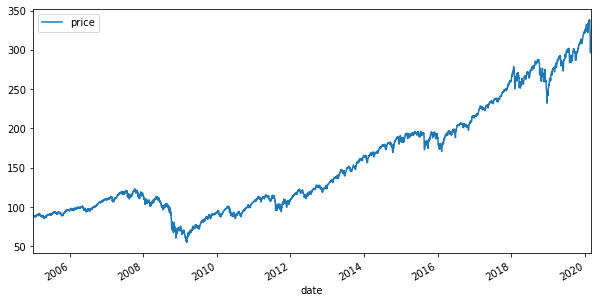

In [6]:
SPY.plot(figsize=(10,5))

In [0]:
data = SPY['price']['2017':]

In [0]:
# Load time series data: S&P 500 price log.
#y = np.loadtxt(open('data/snp500.txt', 'rb'), delimiter=",", skiprows=1)
y = data.values
n = y.size

# Form second difference matrix.
e = np.ones((1, n))
D = sparse.spdiags(np.vstack((e, -2*e, e)), range(3), n-2, n)

# Set regularization parameter.
vlambda = 50

##  Use cvxpy to solve the problem

In [0]:
import cvxpy as cp
import cvxopt as cvxopt

In [12]:
# Solve l1 trend filtering problem.
x = cp.Variable(shape=n)
obj = cp.Minimize(0.5 * cp.sum_squares(y - x)
                  + vlambda * cp.norm(D*x, 1) )
prob = cp.Problem(obj)

# ECOS and SCS solvers fail to converge before
# the iteration limit. Use CVXOPT instead.
prob.solve(solver=cp.CVXOPT, verbose=True)
print('Solver status: {}'.format(prob.status))

# Check for error.
if prob.status != cp.OPTIMAL:
    raise Exception("Solver did not converge!")

print("optimal objective value: {}".format(obj.value))

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -1.0000e+00  2e+06  1e-01  4e-02  1e+00
 1:  2.2669e+02  2.4614e+02  2e+06  1e-01  4e-02  2e+01
 2: -1.4429e+02  3.9345e+00  2e+06  1e-01  4e-02  2e+02
 3: -6.8835e+01  7.0022e+01  1e+06  7e-02  2e-02  1e+02
 4:  4.1348e+02  5.7010e+02  1e+06  7e-02  2e-02  2e+02
 5: -1.2612e+02  1.1485e+02  6e+05  4e-02  1e-02  2e+02
 6:  7.6088e+01  2.5384e+02  4e+05  3e-02  7e-03  2e+02
 7:  9.3038e+02  1.1129e+03  4e+05  3e-02  7e-03  2e+02
 8:  8.0347e+02  8.9064e+02  2e+05  1e-02  3e-03  9e+01
 9:  1.8726e+03  1.9144e+03  7e+04  5e-03  1e-03  4e+01
10:  2.2036e+03  2.2272e+03  4e+04  3e-03  7e-04  2e+01
11:  2.7131e+03  2.7371e+03  4e+04  3e-03  7e-04  2e+01
12:  2.7184e+03  2.7314e+03  2e+04  1e-03  4e-04  1e+01
13:  3.3731e+03  3.3775e+03  7e+03  5e-04  1e-04  4e+00
14:  3.7551e+03  3.7564e+03  2e+03  1e-04  4e-05  1e+00
15:  3.8911e+03  3.8915e+03  8e+02  5e-05  1e-05  5e-01
16:  3.9436e+03  3.9439e+03  4e+02  3e-05  8e-06  

## Results plot

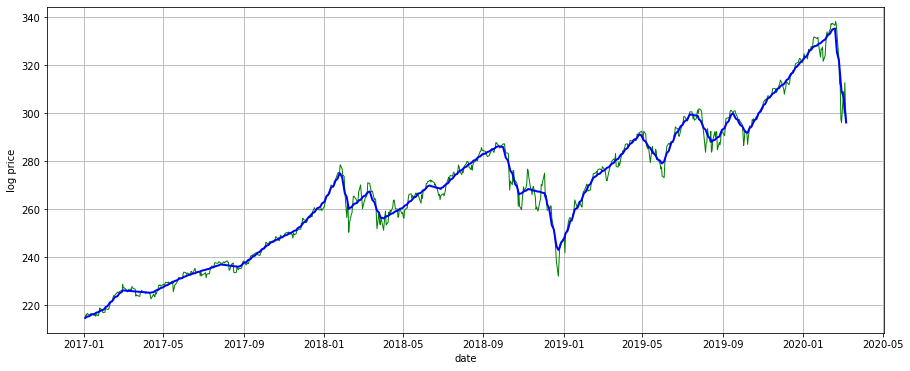

In [14]:
# Plot estimated trend with original signal.
fig,ax = plt.subplots(figsize=(15, 6))
ax.plot(data.index, y, 'g-', linewidth=1.0)
ax.plot(data.index, np.array(x.value), 'b-', linewidth=2.0)
ax.set_xlabel('date')
ax.set_ylabel('log price')
ax.grid()

## Implementing an ADMM (Alternative Direction Method of Multipliers) method

In [0]:
def objective_primal(x,y,vlambda,D):
    return np.linalg.norm(x-y)**2/2 + vlambda*np.linalg.norm(D*x,1)

In [26]:
objective_primal(y,y, vlambda, D)  # if we set x=y

88738.71154785132

In [0]:
def objective_dual(nu, y, vlambda, D):
    if ((nu<=vlambda) & (nu>=-vlambda)).all():
      tmp= D.T.dot(nu)
      return -np.linalg.norm(tmp)**2/2 + y.dot(tmp)
    else:
      return float('-inf')

In [0]:
t = np.random.rand(3)>0)

In [0]:
nu = np.linalg.lstsq(D.T.toarray(), y-x.value, rcond=None)[0]

In [0]:
# make nu dual feable
nu[nu>50]=50
nu[nu<-50]=-50

In [64]:
np.linalg.norm(D.T.dot(nu)-y+x.value)

0.002634294532043211

In [65]:
objective_dual(nu, y, vlambda, D)

3981.0660281483283

In [0]:
  A =1.*D.T.dot(D)+sparse.identity(D.shape[1])

In [82]:
A.shape

(799, 799)

In [0]:
def soft_threshold(v, a):
  return np.maximum(v-a,0) - np.maximum(-v-a,0)

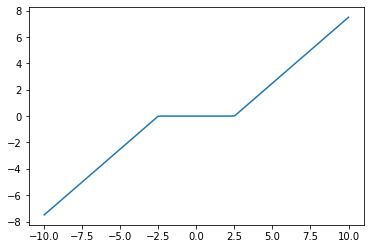

In [85]:
v = np.linspace(-10,10,100)
a = 2.5
plt.plot(v, soft_threshold(v,a))

In [0]:
from scipy.sparse.linalg import spsolve

In [0]:
t = spsolve(A, y)

In [0]:
def ADMM(y, D, vlambda, rho=1.0):
  # initialize
  x = y.copy()
  z = D.dot(x)
  nu = np.zeros(D.shape[0])
  
  A = rho*D.T.dot(D)+sparse.identity(D.shape[1])

  obj_pri = objective_primal(x, y, vlambda, D)
  obj_dua = objective_dual(nu, y, vlambda, D)
  # iteration
  i = 0
  while obj_pri-obj_dua > 0.1 and i < 1000:
    i += 1
    x = spsolve(A, y+rho*D.T*(z-nu/rho))
    z = soft_threshold(D*x+nu/rho, vlambda/rho)
    nu = nu + rho*(D*x-z)

    obj_pri = objective_primal(x, y, vlambda, D)
    obj_dua = objective_dual(nu, y, vlambda, D)
    print(i, np.linalg.norm(D*x-z), obj_pri, obj_dua, obj_pri-obj_dua)
  
  return x, nu

In [105]:
t1, t2 = ADMM(y, D, vlambda, 10.0)

1 68.23432919966356 88738.71154785132 -2195215.8714570603 2283954.5830049114
2 55.01451106842332 66296.33695168834 -390437.6964445143 456734.03339620266
3 21.419585968571464 15865.297541930153 -84164.81228068675 100030.1098226169
4 9.108536576826387 8117.3114670317955 -41690.12180572049 49807.433272752285
5 7.103643224634619 6236.274156902881 -7972.52607464457 14208.800231547451
6 5.854890951421989 5771.952804261268 2698.1559478518566 3073.7968564094117
7 3.3839608774717975 5272.753397309558 2810.970047515848 2461.78334979371
8 3.0987818774652043 5166.693097870827 2904.2205562313193 2262.4725416395077
9 2.913297935995837 5090.612162188591 2999.0044951092746 2091.607667079317
10 2.772187480925272 5035.334224368617 3102.0675069948925 1933.266717373724
11 2.618018362458405 4968.929409661252 3157.987728679119 1810.9416809821332
12 2.474454164414029 4917.685709773037 3212.0230118256222 1705.662697947415
13 2.3587581252994143 4886.649909600903 3267.4446252410044 1619.2052843598985
14 2.21731